###  **Homework 2 -Classiication**

二元分类是机器学习中最基础的问题之一，在这个作业中，你将学会如何做一个二元分类器，来根据人们的个人资料，判断其年收入是否高于50000美元。我们将以两种方法： logistic regression 和 generative model，来达成以上目的。

（注：本文件是广工GDUT机器学习课程第二次作业的内容，资料和代码由助教整理，难免有错误和不足之处，如有出入，一切以老师提供的PPT为准，需要交流探讨可以联系助教QQ。）

### Datadet

This dataset is obtained by removing unnecessary attributes and balancing the ratio between positively and negatively labeled data in the Census-Income (KDD) Data Set, which can be found in UCI Machine Learning Repository. Only preprocessed and one-hot encoded data (i.e. X_train, Y_train and X_test) will be used in this tutorial. Raw data (i.e. train.csv and test.csv) are provided to you in case you are interested in it.

这个数据集是来自UCI Machine Learning Repository 的 Census-Income (KDD) Data Set，train.csv、test_no_label.csv、sample_submission.csv是数据集中原有的数据。本次作业只需要**X_test、X_train、Y_train**这三个文件，train.csv和test.csv这两个原始资料文件则可以提供一些额外的资料。

本课程助教对原数据进行了清洗：

* 移除了一些不必要的数据
* 对离散值进行了one-hot编码
* 平衡了正负标记的数据的比例


*离散特征进行one-hot编码后，编码后的特征，其实每一维度的特征都可以看做是连续的特征。就可以跟对连续型特征的归一化方法一样，对每一维特征进行归一化。比如归一化到[-1,1]，或者归一化到均值为0,方差为1。*

打开X_train与X_test格式相同，以Notepad++打开X_train查看文件格式：
![](https://ai-studio-static-online.cdn.bcebos.com/0ebde38b664a4d62810704c98622fa630a1850bc9a2a4deba775695252901ef0)

是一个类似csv格式的文件，第一行是表头，从第二行开始是具体数据。表头是人们的个人信息，比如年龄、性别、学历、婚姻状况、孩子个数等等。
再用Notepad++打开Y_train文件，进行查看：

![](https://ai-studio-static-online.cdn.bcebos.com/7e3f969bce9043e888a62538536f5c71036d2b7740c14955bb3f422eff4d9f15)

只有两列，第一列是人的编号（ID），第二列是一个label——如果年收入＞50K美元，label就是1；如果年收入≤50K美元，label就是0.

最终，预测结果的保存格式为：第一行表头，总共两列，第一列是id，第二列是label。

![](https://ai-studio-static-online.cdn.bcebos.com/649bce5565814a189c10972af70c65c053ce5004a70547619171f7be202ca799)


### **作业概述**
输入：人们的个人信息

输出：0（年收入≤50K）或1（年收入＞50K）

模型： logistic regression 或者 generative model

## **2 原始代码**

### **数据准备**

导入数据，读入X_train、Y_train、X_test三个文件，输出文件命名为output_{}.csv

In [1]:
import numpy as np
np.random.seed(0)

X_train_fpath = './data/data/X_train'
Y_train_fpath = './data/data/Y_train'
X_test_fpath = './data/data/X_test'
output_fpath = './output_{}.csv'

# 把csv文件转换成numpy的数组
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)


### **标准化（Normalization）**

![](https://ai-studio-static-online.cdn.bcebos.com/6ee9fceca55b4b5e9be33e36123185809800c900c4de4bf4b4ac31cdbd33869f)



In [2]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
        # print(specified_column)
        # 输出列的ID：
        #[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
        #  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
        # ...
        # 504 505 506 507 508 509]
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8) #1e-8防止除零
     
    return X, X_mean, X_std


### **分割测试集和验证集**
  对原来的X_train进行分割，分割比例为train:dev = 9:1。这里没有shuffle，是固定分割。

In [3]:
def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]
 
# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

# 把数据分成训练集和验证集
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))


Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510


### **一些函数的定义**
![](https://ai-studio-static-online.cdn.bcebos.com/d5232e15effa42a1a379a8f44ae553affdb3675c4708476b9399a933e3036361)


In [22]:
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)

def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X, w, b)).astype(np.int)
    
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

## **2.1 Logistic Regression**
### **损失函数（Loss Function）**

![](https://ai-studio-static-online.cdn.bcebos.com/c86e9f2725d14e92bd70e72de3a6985bd13c26c90d914793a8dfe1b1a90411e9)


In [23]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

### **梯度（Gradient）**
![](https://ai-studio-static-online.cdn.bcebos.com/60b254a4f5cd430d8cccec1ef2a8376fd0f3704febad40bb8f7e5f0b0e356085)
![](https://ai-studio-static-online.cdn.bcebos.com/8bc0b5352b3e42cea812373d43cec1bdcc6b6337302e431fa9b5850617787127)
![](https://ai-studio-static-online.cdn.bcebos.com/4c57b06c31fd4f6f8349be9acc5b1915cc2aa1f71a844381ab4a8b934ac8ba66)
![](https://ai-studio-static-online.cdn.bcebos.com/47218d7716264d4082c632f71af3f1332f80c4f515a84fed815cb92e0d1736d8)

因为后面用到了batch（小批次处理，一次同时训练多个数据x[j]来更新参数）。所以函数中输入的x和Y_lable都是1 * N（N是批次大小）的一维数组，每一批次的 w_grad 是N个数据的梯度累加的和。



In [24]:
def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

### **训练（Training）**
使用小批次（mini-batch）的梯度下降法来训练。训练数据被分为许多小批次，针对每一个小批次，我们分别计算其梯度以及损失，并根据该批次来更新模型的参数。当一次循环（iteration）完成，也就是整个训练集的所有小批次都被使用过一次以后，我们将所有训练数据打散并且重新分成新的小批次，进行下一个循环，直到事先设定的循环数量（iteration）达成为止。

* **GD（Gradient Descent）**：就是没有利用Batch Size，用基于整个数据库得到梯度，梯度准确，但数据量大时，计算非常耗时，同时神经网络常是非凸的，网络最终可能收敛到初始点附近的局部最优点。

* **SGD（Stochastic Gradient Descent）**：就是Batch Size=1，每次计算一个样本，梯度不准确，所以学习率要降低。

* **mini-batch SGD**：就是选着合适Batch Size的SGD算法，mini-batch利用噪声梯度，一定程度上缓解了GD算法直接掉进初始点附近的局部最优值。同时梯度准确了，学习率要加大。


这里权重W用了全0初始化，logistic regression 中可以用0初始化，原因如下：
Logistic回归没有隐藏层。 如果将权重初始化为零，则Logistic回归中的第一个示例x将输出零，但Logistic回归的导数取决于不是零的输入x（因为没有隐藏层）。 因此，在第二次迭代（迭代发生在w和b值的更新中，即梯度下降）中，如果x不是常量向量，则权值遵循x的分布并且彼此不同。

In [25]:
# 初始化权重w和b，令它们都为0
w = np.zeros((data_dim,))	#[0,0,0,...,0] 510
b = np.zeros((1,))		 	#[0]

# 训练时的超参数
max_iter = 10
batch_size = 8
learning_rate = 0.2

# 保存每个iteration的loss和accuracy，以便后续画图
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# 累计参数更新的次数
step = 1

# 迭代训练
for epoch in range(max_iter):
    # 在每个epoch开始时，随机打散训练数据
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # Mini-batch训练
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # 计算梯度
        w_grad, b_grad = _gradient(X, Y, w, b)
            
        # 梯度下降法更新
        # 学习率随时间衰减
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
            
    # 计算训练集和验证集的loss和accuracy
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Training loss: 0.2713554352464059
Development loss: 0.2896359675026287
Training accuracy: 0.8836166291214418
Development accuracy: 0.8733873940287504


### **保存weight和bias**
输出weight_logistic.npy和bias_logistic.npy。方便助教调用私有库检查

In [26]:
np.save('weight_logistic.npy',w)
np.save('bias_logistic.npy',b)

### **画出loss和accuracy的曲线**

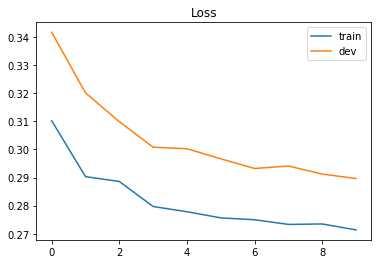

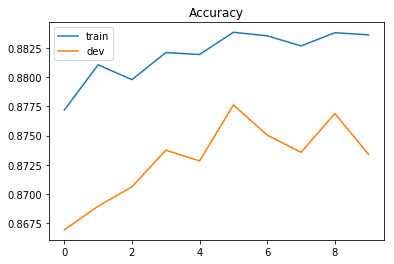

In [27]:
import matplotlib.pyplot as plt

# Loss曲线
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# Accuracy曲线
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

### **测试（test）**
测试集中共有27622个测试数据。预测测试集的标签，并保存在 output_logistic.csv 中。

保存格式为：第一行表头，总共两列，第一列是id，第二列是label：
![](https://ai-studio-static-online.cdn.bcebos.com/532fc7cee1aa48edbb99e4814c1f1d184c507e5feed04c9789e8c06db6e50a34)


In [12]:
# 预测测试集标签
predictions = _predict(X_test, w, b)
# 保存到output_logistic.csv
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# 输出最重要的特征和权重
# 对w的绝对值从大到小排序，输出对应的ID
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
	# 读入表头（特征名）
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Not in universe -4.031960278019251
 Spouse of householder -1.6254039587051405
 Other Rel <18 never married RP of subfamily -1.4195759775765406
 Child 18+ ever marr Not in a subfamily -1.2958572076664743
 Unemployed full-time 1.171255828588591
 Other Rel <18 ever marr RP of subfamily -1.167791807296237
 Italy -1.093458143800618
 Vietnam -1.0630365633146408
num persons worked for employer 0.9389922773566495
 1 0.8226614922117187


## **2.2 概率生成模型（Porbabilistic generative model）**
### **数据预处理**
训练集与测试集的处理方法跟 logistic regression 一模一样，然而因为 generative model 有可解析的最佳解，因此不必使用到验证集（development set）

In [14]:
# 把CSV文件转换为numpy
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

# 标准化训练集和测试集
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

### **均值和协方差（Mean and Covariance）**
在 generative model 中，我们需要分别计算两个类别内的数据的均值和协方差。
* 类别0（y=0）：年收入不超过50,000美元

![](https://ai-studio-static-online.cdn.bcebos.com/00bd47da69844ff8a2eef485693d307d123a79e178bf4cea92c9b685d4963845)
* 类别1（y=1）：年收入超过50,000美元

![](https://ai-studio-static-online.cdn.bcebos.com/93be169a94ef45f594cde4133aa572b79a77bdde88234dbf918e3d9a358377c6)

其中，n0是类别0的个数，n1是类别1的个数。

最终，模型共享的协方差矩阵为所有协方差的加权平均值：![](https://ai-studio-static-online.cdn.bcebos.com/ed724ca7b5504db78c7eaa28a80ef84b7ae9d6cb646c4bc58e8693ecb96db14f)

（这段代码运行时间较长）



In [15]:
# 分别计算类别0和类别1的均值
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0]) 
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0)  

# 分别计算类别0和类别1的协方差
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# 共享协方差 = 独立的协方差的加权求和
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])

### **计算权重和偏差（Computing weights and bias）**
权重矩阵与偏差向量可以直接被计算出来，

![](https://ai-studio-static-online.cdn.bcebos.com/f3236267a98e4e56a3cf4895ec3c3f86ce4283931aff412d8679d8b076ac9fa2)


In [16]:
# 计算协方差矩阵的逆
# 协方差矩阵可能是奇异矩阵, 直接使用np.linalg.inv() 可能会产生错误
# 通过SVD矩阵分解，可以快速准确地获得方差矩阵的逆
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# 计算w和b
w = np.dot(inv, mean_0 - mean_1)
b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# 计算训练集上的准确率
Y_train_pred = 1 - _predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.8714427897375405


### **保存weight和bias**
输出weight_generative.npy和bias_generative.npy。方便助教调用私有库检查.

In [17]:
np.save('weight_generative.npy',w)
np.save('bias_generative.npy',b)

### **测试**
预测测试集的标签，并保存在 output_generative.csv 中。

In [18]:
# 预测测试集的label
predictions = 1 - _predict(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# 输出最重要的几个特征
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Retail trade 7.806640625
 34 -5.94873046875
 37 -5.43212890625
 Other service -5.10986328125
 Different county same state 4.904296875
 Different state in West -4.5634765625
 Yes -4.00390625
 Professional specialty -3.9609375
 Nonmover 3.75830078125
 32 3.61083984375
